In [1]:
import xarray as xr
import netCDF4 as nc
import numpy as np
import pandas as pd
import numpy.ma as ma
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from datetime import datetime, timedelta
import matplotlib.colors as mcolors
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import datetime
import numpy.ma as ma
import glob
import os
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import seaborn as sns
import statsmodels
from scipy.stats import ks_2samp
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures


In [2]:
full_df = pd.read_csv(r"C:\Users\ollie\MSc Data Science\Group Project\crane_temp_rain_tree_pop_veg_turbine_2001-2020.csv")
full_df["OBSERVATION DATE"] = pd.to_datetime(full_df["OBSERVATION DATE"], format="%Y-%m-%d", errors = "coerce")

tree_df = pd.read_csv(r"C:\Users\ollie\MSc Data Science\Group Project\cleaned_tree_cover.csv")
full_df

,GLOBAL UNIQUE IDENTIFIER,OBSERVATION COUNT,COUNTRY,LATITUDE,LONGITUDE,OBSERVATION DATE,TIME OBSERVATIONS STARTED,DURATION MINUTES,AVERAGE MONTH TEMPERATURE,AVERAGE MONTH RAINFALL,country,tree_loss_ha,percentage_loss,Population,NDVI,WT_COUNT_10KM_RADIUS
0,URN:CornellLabOfOrnithology:EBIRD:OBS1550269990,X,Sweden,59.510046,12.371991,2001-06-16,08:00:00,240.0,11.83,54.20,Sweden,144927,0.322027,8907973.24,0.640,0.0
1,URN:CornellLabOfOrnithology:EBIRD:OBS1241571196,1,Netherlands,52.451825,5.370254,2001-03-11,08:00:00,105.0,5.16,76.92,Netherlands,736,0.019540,15959049.96,NaN,0.0
2,URN:CornellLabOfOrnithology:EBIRD:OBS964505541,10,Germany,49.459170,8.678565,2001-11-05,NaN,NaN,3.98,65.96,Germany,15286,0.042718,81554286.00,0.628,0.0
3,URN:CornellLabOfOrnithology:EBIRD:OBS1684568169,3,Sweden,60.436609,16.452448,2001-09-22,08:12:00,285.0,9.08,95.13,Sweden,144927,0.322027,8907973.24,0.744,3299.0
4,URN:CornellLabOfOrnithology:EBIRD:OBS105630429,1,Sweden,58.461900,15.555868,2001-05-21,NaN,NaN,6.85,41.63,Sweden,144927,0.322027,8907973.24,0.524,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84272,URN:CornellLabOfOrnithology:EBIRD:OBS907974657,5,Belarus,51.893125,24.270556,2020-05-01,07:04:00,124.0,11.14,80.49,Belarus,68932,0.332894,9637033.50,0.192,0.0
84273,URN:CornellLabOfOrnithology:EBIRD:OBS849476324,2,Spain,40.986812,-6.062696,2020-01-10,09:26:00,70.0,6.91,69.95,Spain,101988,0.201540,47362016.00,0.616,0.0
84274,URN:CornellLabOfOrnithology:EBIRD:OBS876975681,1,Sweden,59.592077,16.271463,2020-03-11,07:13:00,NaN,-1.77,44.59,Sweden,339968,0.755408,10369622.20,0.308,0.0
84275,URN:CornellLabOfOrnithology:EBIRD:OBS934788467,14,Poland,54.630264,18.485380,2020-05-30,14:04:00,NaN,11.79,64.09,Poland,74959,0.239946,38403282.00,0.200,0.0


In [3]:
country_grouped_tree = tree_df.groupby("country")
country_area = {}
for i, group in country_grouped_tree:
    country_area[i] = group["area_ha"].values[0]

country_area["Sweden"]

45004558

In [4]:
full_df["year"] = full_df["OBSERVATION DATE"].dt.year
tree_loss_df = full_df[["year", "country", "tree_loss_ha"]].drop_duplicates()

crane_counts = full_df.groupby(["year", "country"])["GLOBAL UNIQUE IDENTIFIER"].count().reset_index()
crane_counts.rename(columns={"GLOBAL UNIQUE IDENTIFIER": "crane_sightings"}, inplace=True)
merged_df = pd.merge(crane_counts, tree_loss_df, on=["year", "country"])


area_array = []
for idx, row in merged_df.iterrows():
    area_array.append(country_area[row["country"]])

merged_df["area"] = area_array
merged_df["percentage"] = merged_df["tree_loss_ha"] / merged_df["area"] * 100
merged_df

,year,country,crane_sightings,tree_loss_ha,area,percentage
0,2001,Austria,1,6926,8385802,0.082592
1,2001,Belgium,1,971,3070744,0.031621
2,2001,Canada,10,1358155,983422994,0.138105
3,2001,China,7,230289,938223516,0.024545
4,2001,Denmark,3,4329,4314472,0.100337
...,...,...,...,...,...,...
984,2020,Ukraine,73,79461,60136110,0.132135
985,2020,United Arab Emirates,103,0,7120448,0.000000
986,2020,United Kingdom,186,22842,24548498,0.093048
987,2020,United States,121,1966716,947295610,0.207614


In [5]:
small_df = merged_df[(merged_df["crane_sightings"] < 1000)].sort_values(by = ["crane_sightings"])

In [6]:
corr, pvalue = pearsonr(merged_df["crane_sightings"], merged_df["percentage"])
corr2, pvalue2 = spearmanr(merged_df["crane_sightings"], merged_df["percentage"])
print(f"Pearson correlation: {corr}, pvalue: {pvalue}") 
print(f"Spearman correlation: {corr2}, pvalue: {pvalue2}")

Pearson correlation: 0.1833890825648236, pvalue: 6.2723131422966915e-09
Spearman correlation: 0.3756566861818326, pvalue: 1.6727994045452388e-34


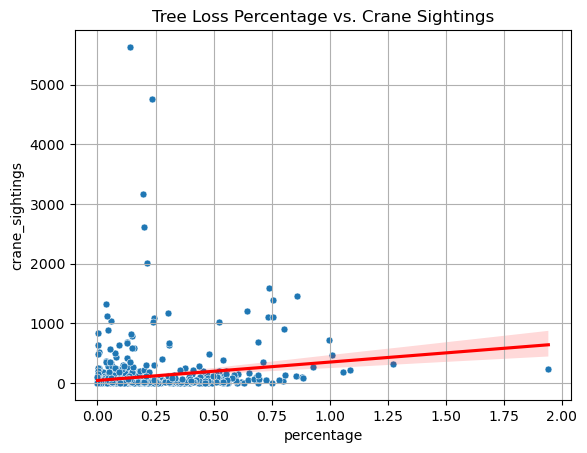

In [7]:
sns.scatterplot(x = merged_df["percentage"], y = merged_df["crane_sightings"], s=25)
sns.regplot(x=merged_df["percentage"], y=merged_df["crane_sightings"], scatter_kws={"alpha":0.5}, line_kws={"color":"red"}, scatter = False)
plt.title("Tree Loss Percentage vs. Crane Sightings")
plt.grid(True)

Lagged Correlation: 0.48203733137056404, P-value: 1.8660804824758284e-49


<Axes: xlabel='tree_loss_lag', ylabel='crane_sightings'>

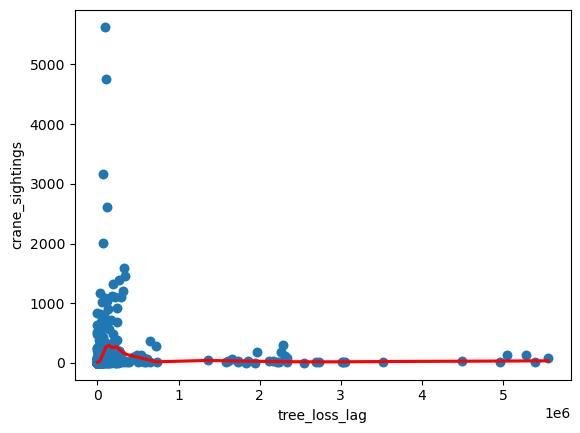

In [38]:
merged_df["tree_loss_lag"] = merged_df.groupby("country")["tree_loss_ha"].shift(2)  # 2-year lag
filtered_df = merged_df.dropna(subset = ["tree_loss_lag"])
correlation, p_value = spearmanr(filtered_df["tree_loss_lag"], filtered_df["crane_sightings"])
print(f"Lagged Correlation: {correlation}, P-value: {p_value}")
plt.scatter(filtered_df["tree_loss_lag"], filtered_df["crane_sightings"])
sns.regplot(x=merged_df["tree_loss_lag"], y=merged_df["crane_sightings"], lowess=True, scatter_kws={"alpha":0.5}, line_kws={"color":"red"})

                             OLS Regression Results                            
Dep. Variable:     log_crane_sightings   R-squared:                       0.125
Model:                             OLS   Adj. R-squared:                  0.124
Method:                  Least Squares   F-statistic:                     140.5
Date:                 Tue, 25 Mar 2025   Prob (F-statistic):           2.17e-30
Time:                         17:43:38   Log-Likelihood:                -1842.7
No. Observations:                  989   AIC:                             3689.
Df Residuals:                      987   BIC:                             3699.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3396      0.061     38.18

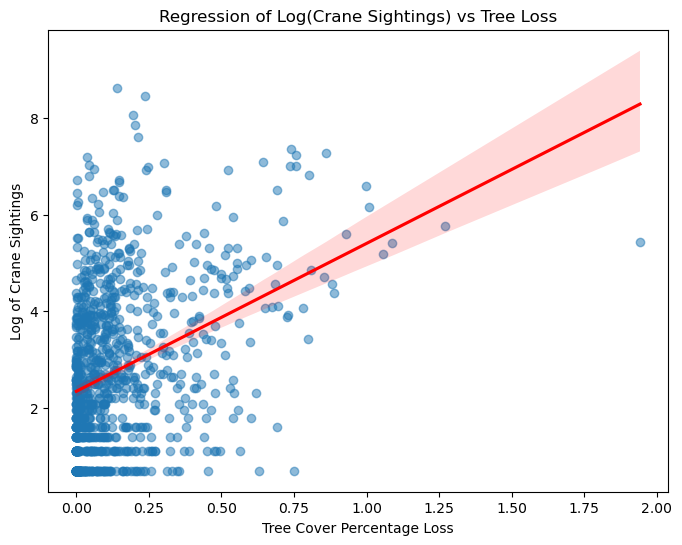

In [16]:
merged_df["log_crane_sightings"] = np.log1p(merged_df["crane_sightings"])

X = merged_df[['percentage']]  # Tree loss percentage
X = sm.add_constant(X)  # Add intercept term for regression
y = merged_df['log_crane_sightings']  # Log-transformed crane sightings

model = sm.OLS(y, X).fit()

# Print regression summary
print(model.summary())

# Plot the results
plt.figure(figsize=(8,6))
sns.regplot(x=merged_df['percentage'], y=merged_df['log_crane_sightings'], scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.xlabel("Tree Cover Percentage Loss")
plt.ylabel("Log of Crane Sightings")
plt.title("Regression of Log(Crane Sightings) vs Tree Loss")
plt.show()

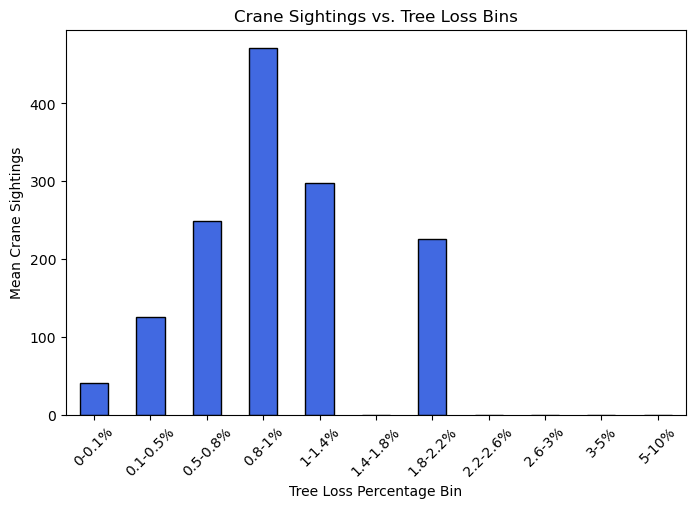

In [18]:
# Define bins (adjust based on data distribution)
bins = [0, 0.1, 0.5, 0.8, 1, 1.4, 1.8, 2.2, 2.6, 3, 5, 10]  # Tree loss percentage ranges
labels = ["0-0.1%", "0.1-0.5%", "0.5-0.8%", "0.8-1%", "1-1.4%", "1.4-1.8%", "1.8-2.2%", "2.2-2.6%", "2.6-3%", "3-5%", "5-10%"]

# Add a new column for binned tree loss
merged_df["tree_loss_bin"] = pd.cut(merged_df["percentage"], bins=bins, labels=labels, include_lowest=True)

# Compute mean crane sightings per bin
mean_sightings = merged_df.groupby("tree_loss_bin")["crane_sightings"].mean()

# Plot the trend
plt.figure(figsize=(8,5))
mean_sightings.plot(kind="bar", color="royalblue", edgecolor="black")

plt.xlabel("Tree Loss Percentage Bin")
plt.ylabel("Mean Crane Sightings")
plt.title("Crane Sightings vs. Tree Loss Bins")
plt.xticks(rotation=45)
plt.show()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.128
Method:                 Least Squares   F-statistic:                     73.58
Date:                Tue, 25 Mar 2025   Prob (F-statistic):           1.65e-30
Time:                        17:54:57   Log-Likelihood:                -1839.7
No. Observations:                 989   AIC:                             3685.
Df Residuals:                     986   BIC:                             3700.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2672      0.068     33.380      0.0

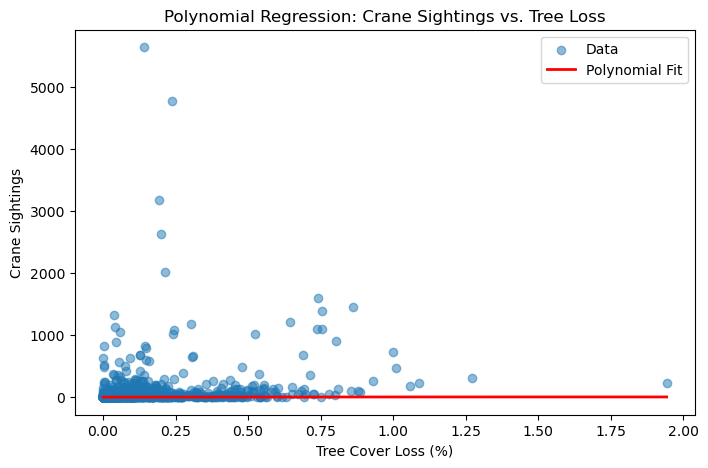

In [22]:
X = merged_df["percentage"].values.reshape(-1, 1)  # Tree loss percentage
y = merged_df["log_crane_sightings"].values          

poly = PolynomialFeatures(degree=2, include_bias=False)  # Change degree if needed
X_poly = poly.fit_transform(X)  # Transforms [X] into [X, X^2] or [X, X^2, X^3]

# Fit OLS model with polynomial features
X_poly = sm.add_constant(X_poly)  # Add intercept
model = sm.OLS(y, X_poly).fit()

# Print summary
print(model.summary())

# Generate predictions for smooth curve
X_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
X_range_poly = poly.transform(X_range)
X_range_poly = sm.add_constant(X_range_poly)
y_pred = model.predict(X_range_poly)

# Plot data and polynomial fit
plt.figure(figsize=(8,5))
plt.scatter(merged_df["percentage"], merged_df["crane_sightings"], alpha=0.5, label="Data")
plt.plot(X_range, y_pred, color="red", linewidth=2, label="Polynomial Fit")
plt.xlabel("Tree Cover Loss (%)")
plt.ylabel("Crane Sightings")
plt.title("Polynomial Regression: Crane Sightings vs. Tree Loss")
plt.legend()
plt.show()